In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


In [2]:
df = pd.read_csv('simulation_results_weather_compensation.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M:%S')
df.set_index('Date', inplace=True)

In [3]:
df.head()

,Outdoor Temperature (°C),Heat Demand (kW),Flow Temperature (°C),Target Flow Temperature (°C),Heat Pump Status,Heat Demand (kWh)
Date,,,,,,
2023-01-01 00:00:00,5.5,2.684074,45.000000,47.261905,On,1.342037
2023-01-01 00:30:00,5.5,1.510222,47.261905,47.261905,On,0.755111
2023-01-01 01:00:00,5.5,0.000000,48.261905,47.261905,Off,0.000000
2023-01-01 01:30:00,5.5,0.000000,47.046629,47.261905,Off,0.000000
2023-01-01 02:00:00,5.5,1.862119,45.883611,47.261905,On,0.931060


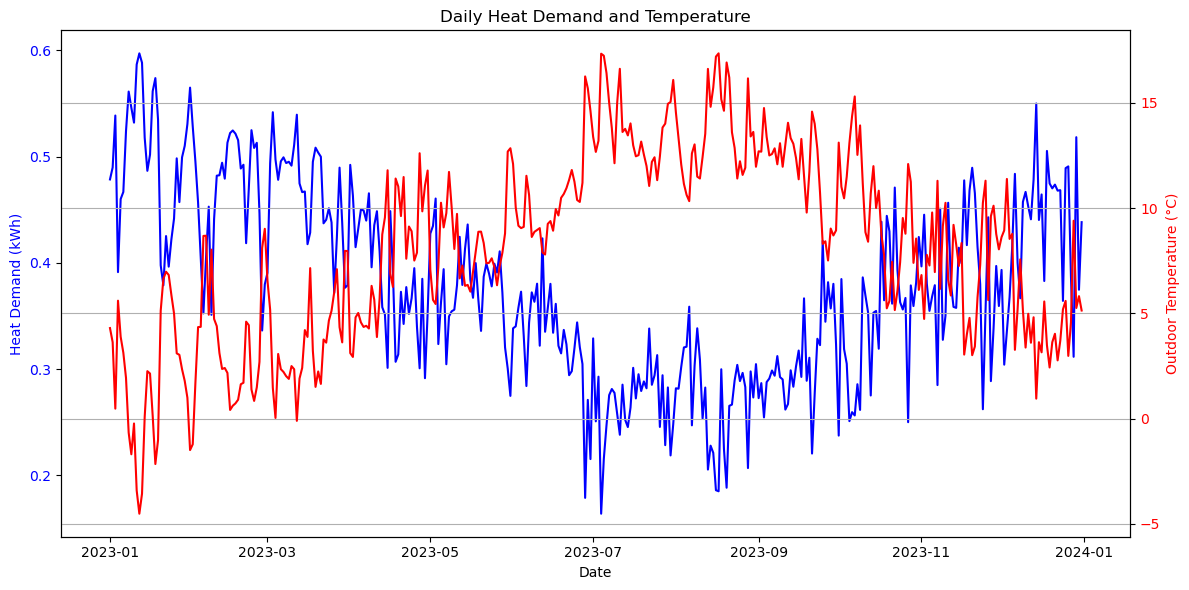

In [4]:
numeric_df = df.select_dtypes(include='number')
daily_df = numeric_df.resample('D').mean()

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Heating Demand on the first y-axis
ax1.plot(daily_df.index, daily_df['Heat Demand (kWh)'], label='Hourly Heat Demand', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Heat Demand (kWh)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(daily_df.index, daily_df['Outdoor Temperature (°C)'], label='Hourly Temperature', color='red')
ax2.set_ylabel('Outdoor Temperature (°C)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and grid
plt.title('Daily Heat Demand and Temperature')
fig.tight_layout()
plt.grid()
plt.show()

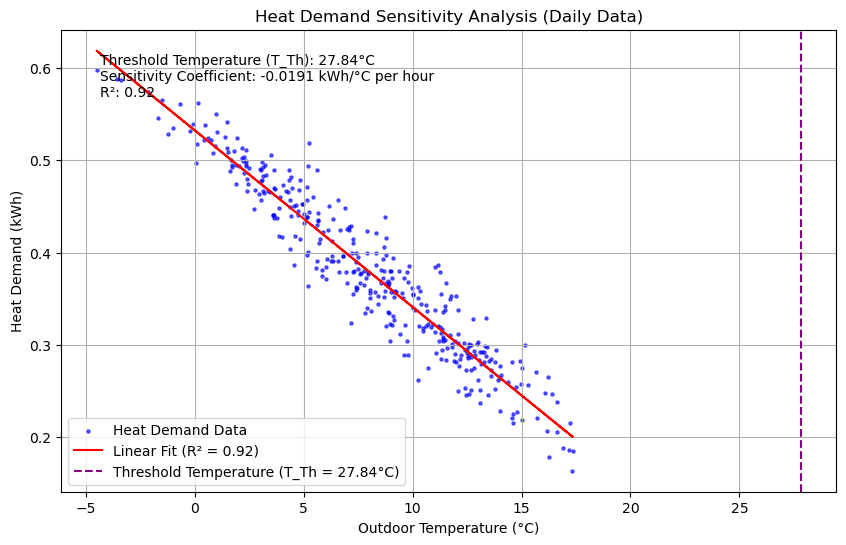

(np.float64(27.8372929385298),
 np.float64(-0.01911805061814216),
 0.9157882110424369)

In [5]:
threshold_demand = 0

# Filter data to include only points with heating demand above the threshold
filtered_data = daily_df[daily_df['Heat Demand (kWh)'] > threshold_demand]

# Reshape temperature values for the regression model
temperatures = filtered_data['Outdoor Temperature (°C)'].values.reshape(-1, 1)
heating_demand = filtered_data['Heat Demand (kWh)'].values

# Fit LR model
linear_model = LinearRegression()
linear_model.fit(temperatures, heating_demand)

# Calculate the sensitivity coefficient 
sensitivity_coefficient = linear_model.coef_[0]

# Calculate the threshold temperature where heating demand becomes zero (intercept with x-axis)
T_Th = -linear_model.intercept_ / sensitivity_coefficient

# Calculate predicted values only within the temperature where heating demand > 0
predicted_temperatures = temperatures[temperatures <= T_Th].reshape(-1, 1)  
predicted_demand = linear_model.predict(predicted_temperatures)

# Calculate R-squared for the model
r2 = r2_score(heating_demand, linear_model.predict(temperatures))


plt.figure(figsize=(10, 6))
plt.scatter(daily_df['Outdoor Temperature (°C)'], daily_df['Heat Demand (kWh)'], s=5, color='blue', alpha=0.6, label='Heat Demand Data')

plt.plot(predicted_temperatures, predicted_demand, color='red', linestyle='-', label=f'Linear Fit (R² = {r2:.2f})')

plt.axvline(x=T_Th, color='purple', linestyle='--', label=f'Threshold Temperature (T_Th = {T_Th:.2f}°C)')

plt.title('Heat Demand Sensitivity Analysis (Daily Data)')
plt.xlabel('Outdoor Temperature (°C)')
plt.ylabel('Heat Demand (kWh)')
plt.text(0.05, 0.95, f"Threshold Temperature (T_Th): {T_Th:.2f}°C\n"
                      f"Sensitivity Coefficient: {sensitivity_coefficient:.4f} kWh/°C per hour\n"
                      f"R²: {r2:.2f}",
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.legend()
plt.grid()
plt.savefig('./figures/sensitivity_analysis_weather_compensation.pdf')
plt.show()

T_Th, sensitivity_coefficient, r2